In [2]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [3]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database


covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
file_name='/content/covid19-radiography-database.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [6]:
import os
imagePaths = []
for dirname, _, filenames in os.walk('/content/COVID-19 Radiography Database'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [7]:
import cv2
import os
import keras

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import applications
from keras.optimizers import Adam
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tqdm import tqdm
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras import backend as K

Text(0.5, 0, '(1024, 1024, 3)')

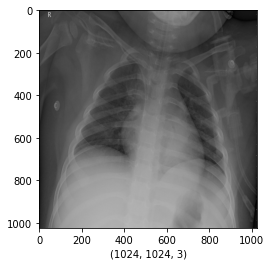

In [8]:

image = cv2.imread(imagePaths[0])
plt.imshow(image)
plt.xlabel(image.shape)


In [9]:
Data = []
Target = []
resize = 224

In [10]:
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(label)

100%|██████████| 2905/2905 [00:44<00:00, 64.74it/s]


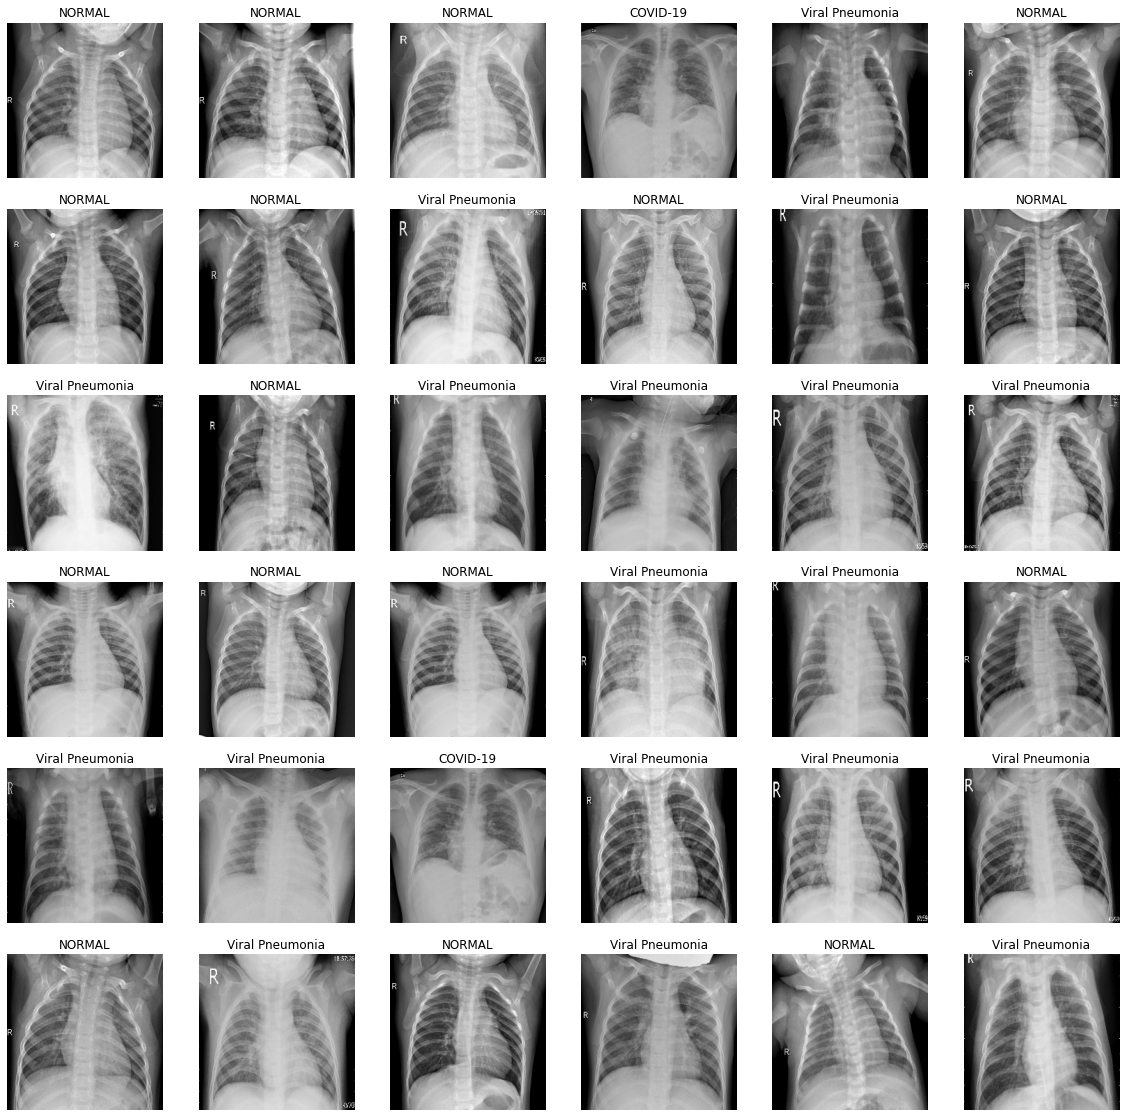

In [11]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(Data),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(Data[i])   
    plt.axis('off')
    plt.title(Target[i])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


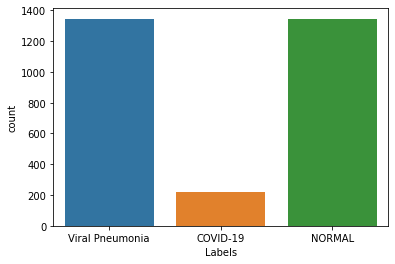

In [12]:
df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])

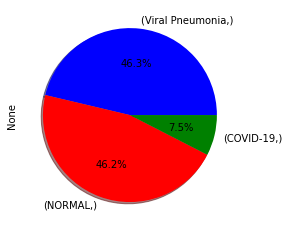

In [13]:
new_df = pd.DataFrame(Target , columns=['Labels'])

colors = ['Blue', 'Red' , 'Green']
new_df.value_counts().plot.pie(autopct='%1.1f%%',shadow=True, colors=colors)

In [14]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Target)
encoded_Target = encoder.transform(Target)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_Target = np_utils.to_categorical(encoded_Target)

In [15]:
print(encoder.classes_)

print(encoded_Target[0])

['COVID-19' 'NORMAL' 'Viral Pneumonia']
[0. 0. 1.]


In [16]:
#Train Test Split
X_train, X_1, y_train, y_1 = train_test_split(np.array(Data), np.array(encoded_Target), test_size=0.2, random_state=42,stratify=encoded_Target)

#Train Test Split
X_cv, X_test, y_cv, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42,stratify=y_1)


In [17]:
del Data
del Target

In [18]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(2324, 224, 224, 3)
(464, 224, 224, 3)
(117, 224, 224, 3)


In [19]:
img_width ,img_height = 224 , 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
    X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
    X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
    
else:
    input_shape = (img_width, img_height, 3)
    X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
    X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
    X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)


In [20]:
#Function to Plott train and Test loss

def plt_dynamic(x,vy,ty,ax,colors=['b']):
  ax.plot(x,vy,'b',label='Validation Loss')
  ax.plot(x,ty,'r',label='Train Loss')
  plt.legend()
  plt.grid()
  fig.canvas.draw()

In [21]:
#Variables defined
epoch = 30
batch = 32
num_classes=3

In [22]:
#Model Defining
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),
                activation='relu',
                input_shape=input_shape,
                kernel_initializer='he_normal'))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax',kernel_initializer='glorot_normal'))

In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [24]:
#Model Compile
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [25]:
his=model.fit(X_train,
              y_train,
              batch_size=batch,
              epochs=epoch,
              verbose=1,
              validation_data=(X_cv,y_cv))

Epoch 1/30
73/73 [==============================] - 3s 39ms/step - loss: 1.8307 - accuracy: 0.3210 - val_loss: 0.9399 - val_accuracy: 0.4698
Epoch 2/30
73/73 [==============================] - 2s 31ms/step - loss: 1.2927 - accuracy: 0.4320 - val_loss: 0.9069 - val_accuracy: 0.4612
Epoch 3/30
73/73 [==============================] - 2s 31ms/step - loss: 1.1517 - accuracy: 0.4565 - val_loss: 0.8921 - val_accuracy: 0.5151
Epoch 4/30
73/73 [==============================] - 2s 31ms/step - loss: 1.0006 - accuracy: 0.5250 - val_loss: 0.9955 - val_accuracy: 0.4655
Epoch 5/30
73/73 [==============================] - 2s 31ms/step - loss: 0.8571 - accuracy: 0.6407 - val_loss: 6.8143 - val_accuracy: 0.4612
Epoch 6/30
73/73 [==============================] - 2s 32ms/step - loss: 1.0183 - accuracy: 0.4759 - val_loss: 0.8904 - val_accuracy: 0.5086
Epoch 7/30
73/73 [==============================] - 2s 31ms/step - loss: 0.9897 - accuracy: 0.4854 - val_loss: 0.8658 - val_accuracy: 0.5539
Epoch 8/30
73

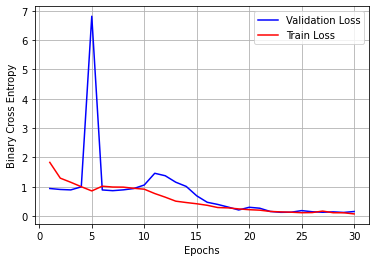

In [26]:
#Plotting Train and Validation Loss
fig,ax=plt.subplots(1,1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Binary Cross Entropy')

x=list(range(1,epoch+1))

vy=his.history['val_loss']
ty=his.history['loss']
plt_dynamic(x,vy,ty,ax)

In [27]:
#Test Accuracy
score=model.evaluate(X_test,y_test,verbose=0)
print("The test accuracy for the model is %f "%(score[1]*100))

The test accuracy for the model is 97.435898 


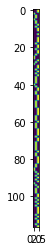

In [29]:
y_pred=model.predict(X_test).round()
plt.imshow(y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

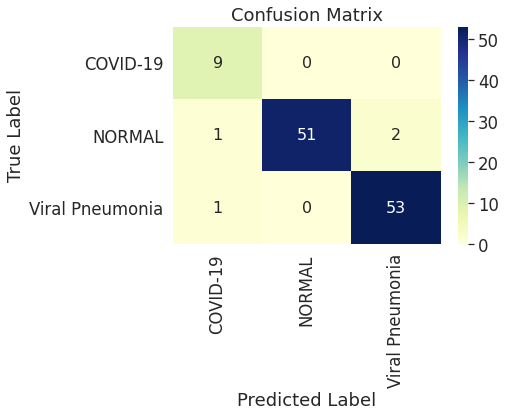

In [30]:
#Plotting Confusion Matrix
x=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
Cm_df=pd.DataFrame(x,index=encoder.classes_,columns=encoder.classes_)

sns.set(font_scale=1.5,color_codes=True,palette='deep')
sns.heatmap(Cm_df,annot=True,annot_kws={'size':16},fmt='d',cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix')

In [31]:
model.save('covid19_new_model.h5')


In [32]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

4/4 [==============================] - 0s 9ms/step - loss: 0.1485 - accuracy: 0.9744
Test Loss is 0.14850617945194244
Test Accuracy is 0.9743589758872986
